In [61]:
#install.packages("rgdal")
library(dplyr)
library(tidyr)
library(ggplot2)
library(sp)
library(gstat)
library(raster)
library(scales) # for "comma"
library(tiff)
library(rgdal)
library(elevatr)
library(fields)

In [49]:
stn80 <- read.csv("stn80.csv", stringsAsFactors=FALSE)

numFiles <- length(stn80$ID)

df <- data.frame( year = rep(c(2015:2015)), month = rep(c(1:12)))

for (i in 1:numFiles) {
#i = 1
    df$ID <- stn80$ID[i]

    fname <- paste0(stn80$ID[i],".csv")
    stnf <- read.csv(fname, stringsAsFactors=FALSE)  ## read the file for the current station

    ## select only the TMAX elements from the incoming file, and merge with the data frame df.
    ## Use gather (from tidyr) to convert the daily data from row to columns.
    stntmax <- stnf[stnf$element == "TMAX", -c(1,8)]
    stntmax1 <- gather(stntmax, key = "day", value = "TMAX", Val1:Val31)  ## create one line for each day
    stntmax1$day <- as.integer(substring(stntmax1$day, 4, last = 1000000L)) 
    ## label the day by the integer after "Val". last = 1000000L means go to the end of the string.

    ## repeat for TMIN, merge TMIN data frame with TMAX dataframe into the output dataframe
    stntmin <- stnf[stnf$element == "TMIN", -c(1,8)]
    stntmin1 <- gather(stntmin, key = "day", value = "TMIN", Val1:Val31)
    stntmin1$day <- as.integer(substring(stntmin1$day, 4, last = 1000000L))
    outfr <- merge(stntmax1, stntmin1, all = TRUE)


    ## repeat for PRCP, and merge with output dataframe
    stnprcp <- stnf[stnf$element == "PRCP", -c(1,8)]
    stnprcp1 <- gather(stnprcp, key = "day", value = "PRCP", Val1:Val31)
    stnprcp1$day <- as.integer(substring(stnprcp1$day, 4, last = 1000000L))
    outfr <- merge(outfr, stnprcp1, all=TRUE)

    outfr = outfr[order(outfr$month, outfr$day),]

    ## save the file
    outfile <- paste0( stn80$ID[i],"_80.csv")
    write.csv(outfr, outfile)

}

In [208]:
stn80 <- read.csv("stn80.csv", stringsAsFactors=FALSE)

numFiles <- length(stn80$ID)

df <- data.frame(matrix(ncol = 16, nrow = numFiles))
colnames(df) <- c("ID", "LON", "LAT", "ELEV", "AvgTemp1", "AvgTemp2", "AvgTemp3", "AvgTemp4", "AvgTemp5"
                 , "AvgTemp6", "AvgTemp7", "AvgTemp8", "AvgTemp9", "AvgTemp10", "AvgTemp11", "AvgTemp12")


for (i in 1:numFiles) {
    fname <- paste0(stn80$ID[i],"_80.csv")
    tempf <- read.csv(fname, stringsAsFactors=FALSE)
    df$ID[i] = tempf$ID[i]
    df$LAT[i] = tempf$LAT[i]
    df$LON[i] = tempf$LON[i]
    df$ELEV[i] = tempf$ELEV[i]
    for (j in 1:12){
        tmax = mean(tempf[tempf$month == j,]$TMAX, na.rm = TRUE)
        tmin = mean(tempf[tempf$month == j,]$TMIN, na.rm = TRUE)
        tavg = (tmax + tmin)/2
        df[i,4+j] = tavg
    }
}
summary(df)
df = na.omit(df)
summary(df)

xy <- df[,c(2,3)]
spdf <- SpatialPointsDataFrame(coords = xy, data = df,
                               proj4string = CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
dim(spdf)

      ID                 LON              LAT             ELEV     
 Length:331         Min.   :-109.1   Min.   :37.01   Min.   :1037  
 Class :character   1st Qu.:-107.3   1st Qu.:38.05   1st Qu.:1672  
 Mode  :character   Median :-106.0   Median :39.12   Median :2395  
                    Mean   :-105.9   Mean   :39.04   Mean   :2348  
                    3rd Qu.:-105.1   3rd Qu.:39.94   3rd Qu.:2957  
                    Max.   :-102.1   Max.   :40.99   Max.   :3542  
                    NA's   :6        NA's   :6       NA's   :6     
    AvgTemp1           AvgTemp2         AvgTemp3          AvgTemp4     
 Min.   :-127.887   Min.   :-76.54   Min.   :-44.617   Min.   :-14.13  
 1st Qu.: -45.000   1st Qu.:-37.33   1st Qu.:  1.903   1st Qu.: 18.42  
 Median : -25.500   Median :-12.85   Median : 28.903   Median : 47.43  
 Mean   : -26.554   Mean   :-12.34   Mean   : 31.908   Mean   : 54.95  
 3rd Qu.:  -4.492   3rd Qu.: 10.60   3rd Qu.: 63.823   3rd Qu.: 91.13  
 Max.   :  34.032   Max.

      ID                 LON              LAT             ELEV     
 Length:302         Min.   :-109.1   Min.   :37.01   Min.   :1037  
 Class :character   1st Qu.:-107.3   1st Qu.:38.00   1st Qu.:1703  
 Mode  :character   Median :-106.1   Median :39.10   Median :2444  
                    Mean   :-106.0   Mean   :39.02   Mean   :2376  
                    3rd Qu.:-105.1   3rd Qu.:39.94   3rd Qu.:3016  
                    Max.   :-102.1   Max.   :40.97   Max.   :3542  
    AvgTemp1           AvgTemp2         AvgTemp3          AvgTemp4     
 Min.   :-127.887   Min.   :-76.54   Min.   :-44.617   Min.   :-14.13  
 1st Qu.: -44.464   1st Qu.:-37.13   1st Qu.:  2.246   1st Qu.: 18.06  
 Median : -25.728   Median :-13.38   Median : 27.847   Median : 46.37  
 Mean   : -26.036   Mean   :-12.34   Mean   : 31.725   Mean   : 53.84  
 3rd Qu.:  -4.179   3rd Qu.: 10.72   3rd Qu.: 63.641   3rd Qu.: 90.09  
 Max.   :  34.032   Max.   : 54.73   Max.   :102.710   Max.   :134.70  
    AvgTemp5        

[1] 302  16

In [209]:
bbox(spdf)
identical( coordinates(spdf), spdf@coords )
df

min       max      
LON -109.0528 -102.1317
LAT   37.0103   40.9683

[1] TRUE

ID          LON       LAT     ELEV   AvgTemp1     AvgTemp2    AvgTemp3  
1   USC00050109 -103.1417 40.1550 1384.4  -15.9032258   6.0357143  70.096774
2   USC00050128 -105.8569 37.4703 2298.2  -53.4677419 -13.8571429  39.258065
3   USC00050214 -108.3808 39.4992 1718.2  -15.9193548  22.3392857  67.967742
4   USC00050263 -105.8914 38.9931 2724.6  -70.0483871 -53.0714286  -6.933333
5   USC00050306 -102.1614 38.6842 1239.0    0.9354839  12.8750000  72.629032
6   USC00050372 -106.8381 39.1853 2491.7  -40.4838710 -19.9642857  17.580645
7   USC00050454 -105.4764 39.4053 2362.8  -33.4516129 -30.5000000  19.419355
8   USC00050754 -107.6872 38.5547 2484.4  -24.6612903   3.7857143  41.758065
9   USC00050756 -104.8017 39.0294 2120.5   10.7580645  10.1428571  47.354839
10  USC00050797 -107.1678 38.4667 2306.7 -116.3064516 -41.1607143   7.838710
11  USC00050825 -107.8989 39.1025 3002.9  -55.4838710 -46.8214286 -22.645161
13  USC00050848 -105.2667 39.9919 1671.5   24.5967742  25.2678571  78.145161
15  USC00050950 -104.8361 39.9436 1528.9    1.5000000   8.3035714  63.467742
16  USC00051060 -105.2969 40.6158 2255.5    7.7096774  -3.9821429  43.016129
17  USC00051071 -106.1275 38.8247 2424.4  -12.8548387   0.6785714  39.983871
18  USC00051121 -102.2608 39.3061 1268.6   -2.2419355   8.6428571  71.983871
20  USC00051186 -105.7089 39.6553 3054.1  -38.4516129 -39.8571429  -4.080645
21  USC00051268 -102.5536 37.0103 1251.2   22.0806452  30.5535714  89.370968
22  USC00051294 -105.2256 38.4600 1639.2   17.9516129  27.0178571  71.516129
23  USC00051401 -104.9058 39.4106 1885.2    3.0148221  27.8853755  52.350000
24  USC00051443 -107.8914 38.9044 2084.2   -9.0967742  24.1428571  63.516129
25  USC00051528 -105.2783 39.2203 2097.0    1.4032258   3.0178571  46.816667
26  USC00051539 -103.5100 38.1150 1264.0   -5.7193548  18.8571429  67.935484
27  USC00051564 -102.3328 38.8575 1281.1   -1.4354839   9.4821429  73.322581
28  USC00051609 -107.5569 38.4433 2100.1  -57.0967742  -6.3571429  34.790323
29  USC00051620 -102.6967 40.3964 1243.9  -25.9565217   4.9800000  59.017857
30  USC00051660 -106.1897 39.3672 3457.7  -76.2903226 -66.1607143 -39.322581
31  USC00051681 -105.3847 39.8958 2728.0  -26.1935484 -36.1071429  14.500000
32  USC00051713 -106.7617 38.4431 2440.2 -127.8870968 -66.6071429 -15.951613
33  USC00051743 -107.9797 39.2367 1831.5  -31.6290323  18.6607143  63.661290
⋮   ⋮           ⋮         ⋮       ⋮      ⋮            ⋮           ⋮         
302 USS0008M10S -108.0200 37.4400 3287.3 -26.064516   -18.160714    8.500000
303 USS0008M12S -108.1800 37.7900 3529.6 -35.516129   -31.946429   -1.354839
304 USW00003013 -102.6881 38.0700 1129.0   2.129032    14.839286   80.048387
305 USW00003016 -107.7264 39.5264 1685.5  -9.580645    26.339286   72.112903
306 USW00003017 -104.6575 39.8328 1650.2  10.838710    10.535714   72.677419
307 USW00003026 -102.2842 39.2447 1277.7  -2.193548     4.714286   74.306452
308 USW00003028 -102.6139 37.2833 1335.9  13.822581    14.053571   73.290323
309 USW00003060 -107.6928 38.5439 2560.9 -26.919355    -3.089286   31.677419
310 USW00003061 -108.5036 37.2553 2448.8  -2.048387    23.767857   64.516129
311 USW00003063 -103.8225 37.8639 1336.9   9.950000    13.767857   71.451613
312 USW00023061 -105.8614 37.4389 2296.1 -51.790323   -21.875000   41.774194
313 USW00023062 -104.8694 39.7633 1611.2   8.666667    10.053571   63.645161
314 USW00023066 -108.5400 39.1342 1480.7  -1.983871    40.553571   88.080645
315 USW00023067 -103.5122 38.0494 1278.3  17.189655    29.357143   88.048387
316 USW00023070 -104.3378 37.2622 1749.9  11.661828    17.589286   78.661290
317 USW00024015 -103.2167 40.1667 1421.3 -17.870968     4.321429   73.790323
318 USW00024046 -107.5211 40.4953 1885.5 -63.516129     1.625000   41.709677
319 USW00093005 -107.7597 37.1431 2030.0 -19.274194    19.750000   58.612903
320 USW00093009 -106.3169 39.2292 3027.3 -55.580645   -56.500000  -22.616240
321 USW00093010 -103.7158 39.1894 1634.9 -14.532258   -13.000000   42.419355


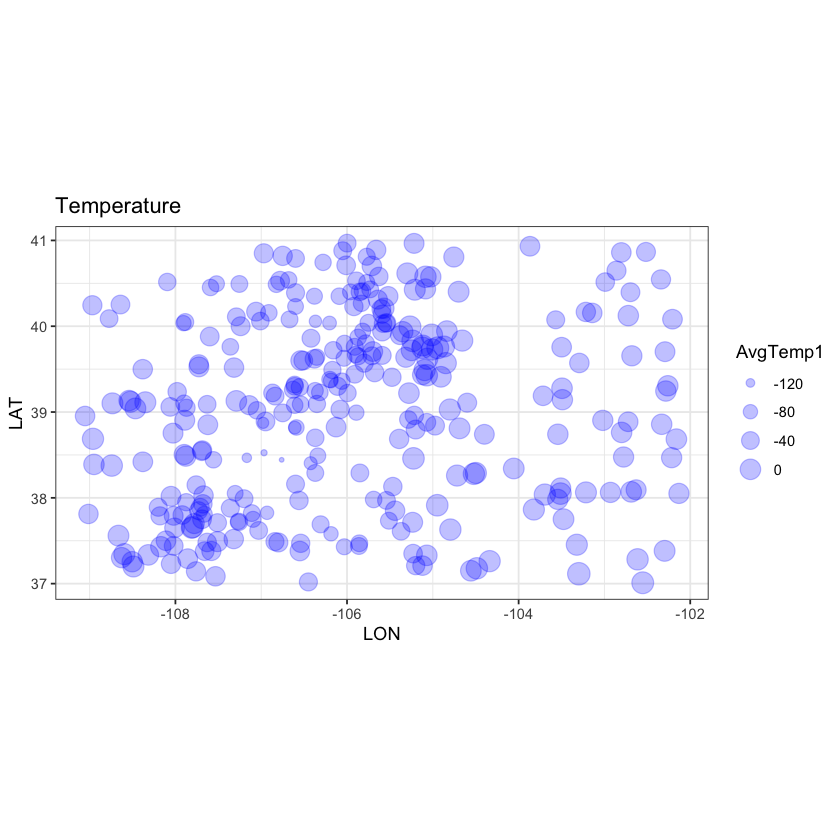

In [210]:
ggplot(aes(LON, LAT), data = df) + geom_point(aes(size=AvgTemp1), color="blue", alpha=1/4, data = df) + 
ggtitle("Temperature") + coord_equal() + theme_bw()

In [107]:
lzn.vgm <- variogram(AvgTemp1~LAT + ELEV, spdf) # calculates sample variogram values 
lzn.fit <- fit.variogram(lzn.vgm, model=vgm("Sph")) # fit model

Warning message in wkt(obj):
“CRS object has no comment”


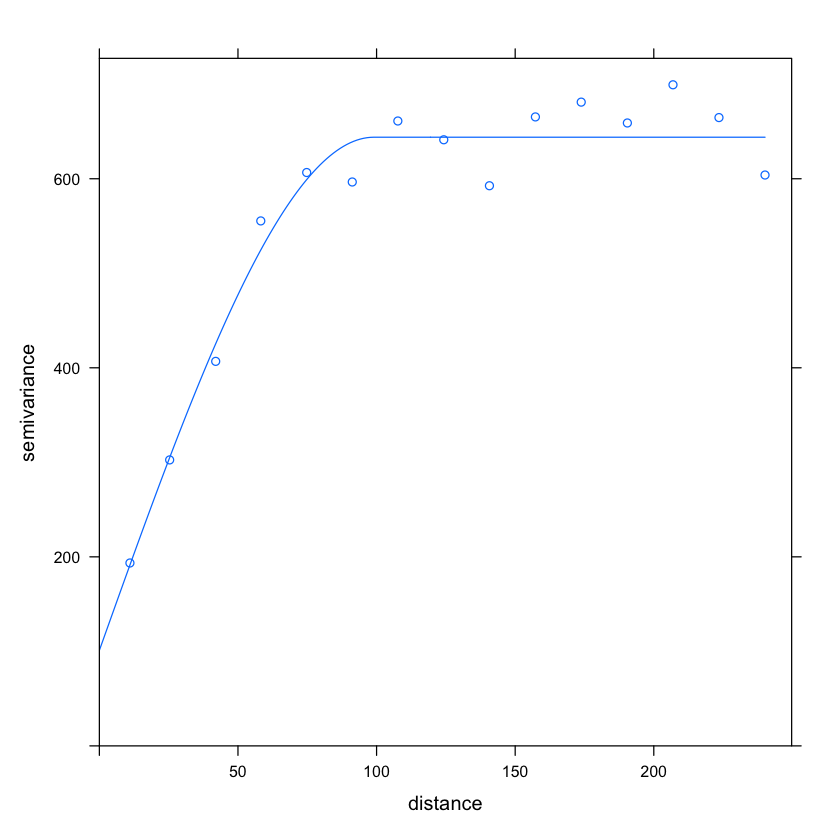

In [108]:
plot(lzn.vgm, lzn.fit) # plot the sample values, along with the fit model

In [138]:
x <- seq(min(df$LON), max(df$LON), length.out=100)
y <- seq(min(df$LAT), max(df$LAT), length.out=100)

d1 <- expand.grid(LON = x, LAT = y)

spdf.grid <- SpatialPointsDataFrame(coords = d1, data = d1,
                               proj4string = CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
prj_dd <- "EPSG:4326"

In [139]:
df_elev_epqs <- get_elev_point(spdf.grid, prj = prj_dd, src = "epqs")

Warning message in spTransform(xSP, CRSobj, ...):
“NULL source CRS comment, falling back to PROJ string”
Warning message in wkt(obj):
“CRS object has no comment”

Note: Elevation units are in meters



In [145]:
spdf.grid$ELEV = c(df_elev_epqs$elevation)

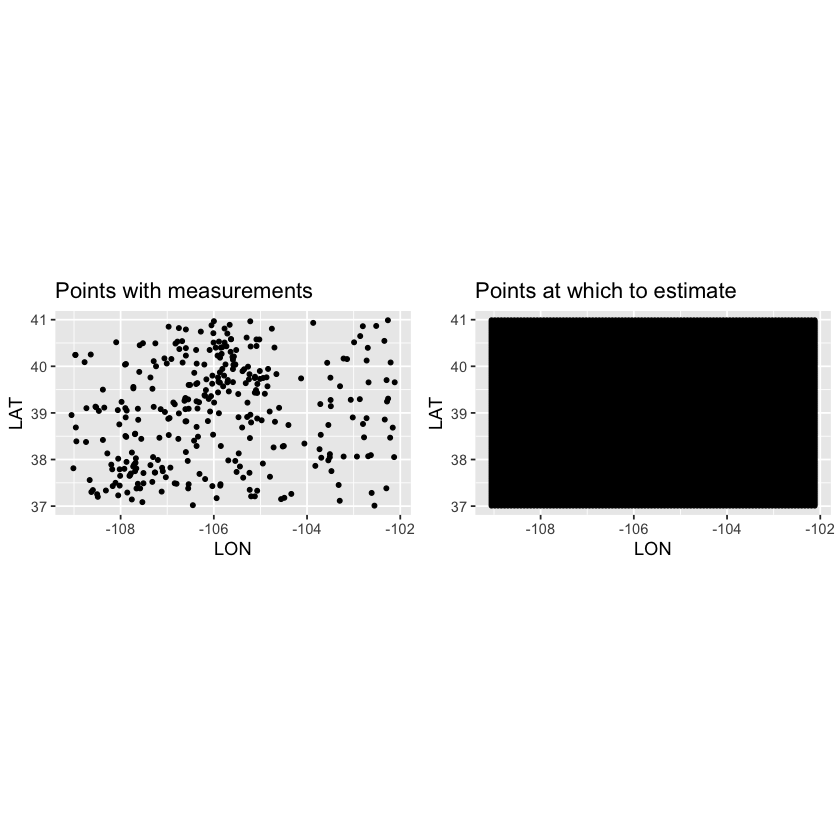

In [141]:
plot1 <- spdf %>% as.data.frame %>%
  ggplot(aes(LON, LAT)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points with measurements")

# this is clearly gridded over the region of interest
plot2 <- spdf.grid %>% as.data.frame %>%
  ggplot(aes(LON, LAT)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points at which to estimate")

library(gridExtra)
grid.arrange(plot1, plot2, ncol = 2)

In [142]:
lzn.kriged <- krige(AvgTemp1 ~ LAT + ELEV, spdf, spdf.grid, model=lzn.fit)

Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”


[using universal kriging]


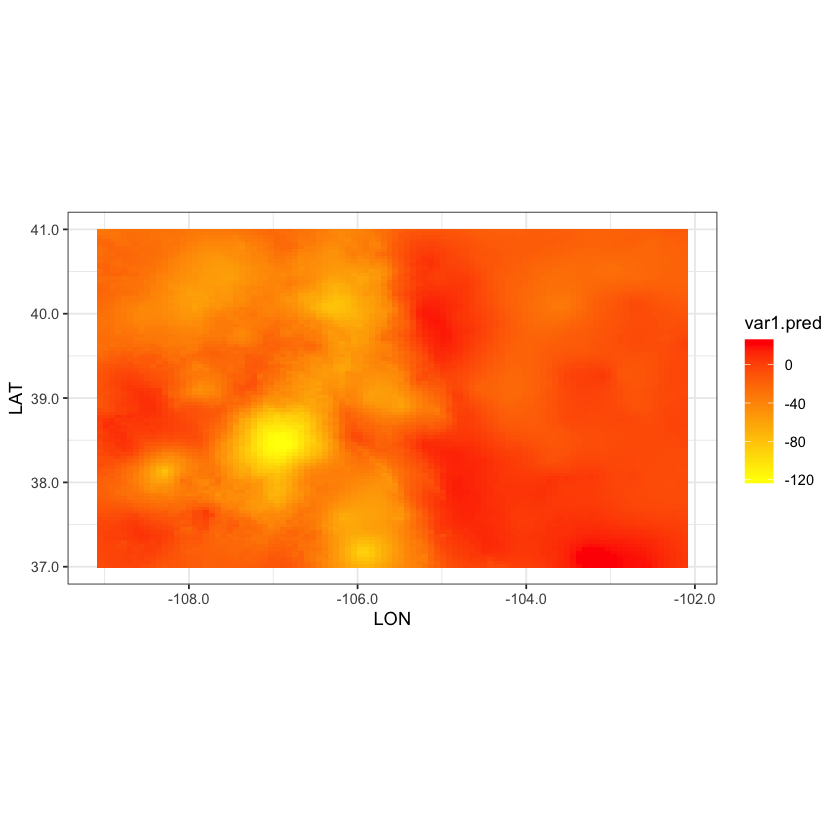

In [143]:
lzn.kriged %>% as.data.frame %>%
  ggplot(aes(x=LON, y=LAT)) + geom_tile(aes(fill=var1.pred)) + coord_equal() +
  scale_fill_gradient(low = "yellow", high="red") +
  scale_x_continuous(labels=comma) + scale_y_continuous(labels=comma) +
  theme_bw()

Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”
Warning message in wkt(obj):
“CRS object has no comment”


[using ordinary kriging]


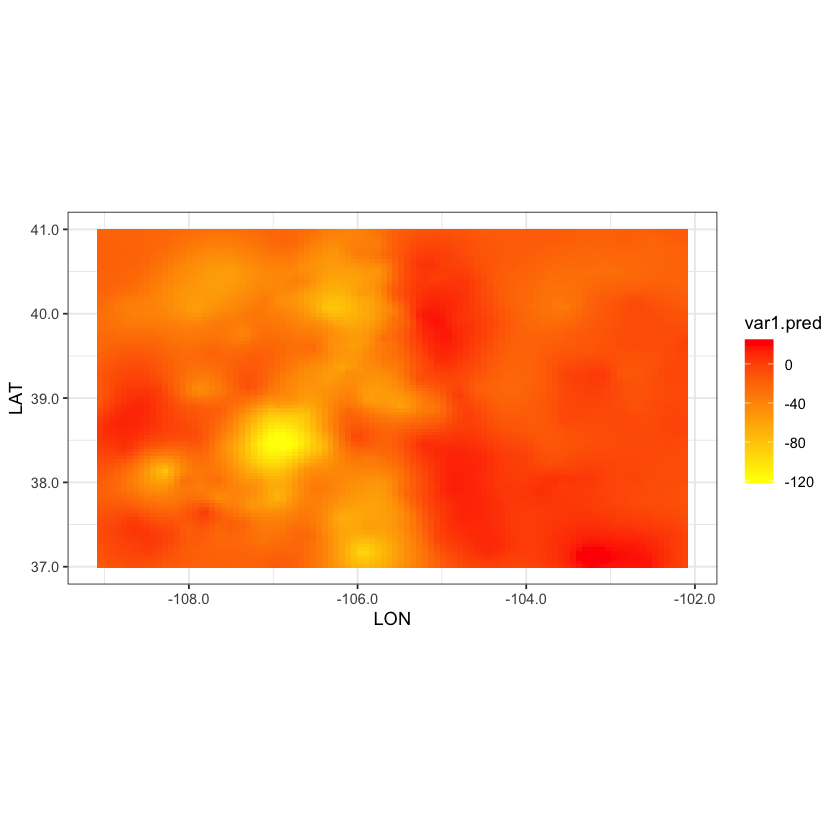

In [144]:
lznBase.vgm <- variogram(AvgTemp1~1, spdf) # calculates sample variogram values 
lznBase.fit <- fit.variogram(lzn.vgm, model=vgm("Sph")) # fit model
x <- seq(min(df$LON), max(df$LON), length.out=100)
y <- seq(min(df$LAT), max(df$LAT), length.out=100)

d1 <- expand.grid(LON = x, LAT = y)

spdfBase.grid <- SpatialPointsDataFrame(coords = d1, data = d1,
                               proj4string = CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
lznBase.kriged <- krige(AvgTemp1 ~ 1, spdf, spdf.grid, model=lzn.fit)

lznBase.kriged %>% as.data.frame %>%
  ggplot(aes(x=LON, y=LAT)) + geom_tile(aes(fill=var1.pred)) + coord_equal() +
  scale_fill_gradient(low = "yellow", high="red") +
  scale_x_continuous(labels=comma) + scale_y_continuous(labels=comma) +
  theme_bw()

In [ ]:
lznBase.vgm <- variogram(AvgTemp1~1, spdf) # calculates sample variogram values 
lznBase.fit <- fit.variogram(lzn.vgm, model=vgm("Sph")) # fit model
x <- seq(min(df$LON), max(df$LON), length.out=100)
y <- seq(min(df$LAT), max(df$LAT), length.out=100)

d1 <- expand.grid(LON = x, LAT = y)

spdfBase.grid <- SpatialPointsDataFrame(coords = d1, data = d1,
                               proj4string = CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))
lznBase.kriged <- krige(AvgTemp1 ~ 1, spdf, spdf.grid, model=lzn.fit)

lznBase.kriged %>% as.data.frame %>%
  ggplot(aes(x=LON, y=LAT)) + geom_tile(aes(fill=var1.pred)) + coord_equal() +
  scale_fill_gradient(low = "yellow", high="red") +
  scale_x_continuous(labels=comma) + scale_y_continuous(labels=comma) +
  theme_bw()